In [20]:
%run ./resources/library.py

In [21]:
style_notebook()

# Notebook 6 - Drawing an Isochrone Map with OSMnx for Soho District in London (Part 2)

## Learning Objectives

By the end of this notebook, you should be able to:

1. Describe the steps to identify points within isochrone polygons.
2. Load shapefiles into Geopandas dataframes and into Folium

## Counting points within isochrone polygons

In [22]:
import geopandas as gpd
import pandas as pd

gpd.__version__

'0.5.1'

In [23]:
trip_times = [1, 5, 10, 15]  # in minutes

BROAD_STREET_PUMP_COORDINATES = (51.513341, -0.136668)

### Set CRS to WGS84 lon/lat projection

In [24]:
wgs84_crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

### Load Cholera data

In [25]:
deaths_gdf = gpd.read_file('outputs/deaths.shp')
pumps_gdf = gpd.read_file('outputs/pumps.shp')
pumps_df = pd.read_pickle('outputs/pumps_df.pickle')

In [27]:
deaths_gdf

,FID,DEATHS,LON,LAT,geometry
0,0,3,-0.137930,51.513418,POINT (-0.1379300000000012 51.51341799999999)
1,1,2,-0.137883,51.513361,POINT (-0.1378830000000002 51.513361)
2,2,1,-0.137853,51.513317,POINT (-0.1378530000000005 51.513317)
3,3,1,-0.137812,51.513262,POINT (-0.1378120000000002 51.51326199999999)
4,4,4,-0.137767,51.513204,POINT (-0.1377670000000004 51.51320399999998)
5,5,2,-0.137537,51.513184,POINT (-0.1375370000000014 51.513184)
6,6,2,-0.138200,51.513359,POINT (-0.1382000000000013 51.51335899999999)
7,7,2,-0.138045,51.513328,POINT (-0.1380449999999999 51.51332799999999)
8,8,3,-0.138276,51.513323,POINT (-0.1382759999999996 51.513323)
9,9,2,-0.138223,51.513427,POINT (-0.1382230000000004 51.513427)


In [28]:
pumps_gdf

,FID,LON,LAT,Street,center_nod,geometry
0,250,698675.096032,5.710800e+06,Broadwick Street,25473293,POINT (-0.1366680000000003 51.513341)
1,251,698470.339243,5.710852e+06,Kingly Street,21665926,POINT (-0.1395860000000003 51.513876)
2,252,698459.963825,5.710966e+06,Ramillies Place,4684520654,POINT (-0.1396710000000016 51.514906)
3,253,699028.900675,5.710704e+06,Dean Street,107807,POINT (-0.1316300000000003 51.51235399999999)
4,254,698893.586170,5.710675e+06,Rupert Street,348875443,POINT (-0.1335939999999998 51.512139)
5,255,698734.889090,5.710602e+06,Bridle Lane,25473300,POINT (-0.1359190000000003 51.511542)
6,256,698877.292713,5.710438e+06,Regent Street,1663004187,POINT (-0.1339620000000002 51.51001899999999)
7,257,698577.787009,5.710569e+06,Warwick Street,25257692,POINT (-0.1381989999999994 51.51129500000001)


In [29]:
pumps_df

,FID,LON,LAT,Street,center_node
0,250,-0.136668,51.513341,Broadwick Street,25473293
1,251,-0.139586,51.513876,Kingly Street,21665926
2,252,-0.139671,51.514906,Ramillies Place,4684520654
3,253,-0.131630,51.512354,Dean Street,107807
4,254,-0.133594,51.512139,Rupert Street,348875443
5,255,-0.135919,51.511542,Bridle Lane,25473300
6,256,-0.133962,51.510019,Regent Street,1663004187
7,257,-0.138199,51.511295,Warwick Street,25257692


### Load isochrone polygons from shapefiles to a dictionary of geodataframes

In [30]:
poly_gdf = {}
poly_gdf[15] = gpd.read_file('outputs/isopoly_15.shp')
poly_gdf[10] = gpd.read_file('outputs/isopoly_10.shp')
poly_gdf[5] = gpd.read_file('outputs/isopoly_5.shp')
poly_gdf[1] = gpd.read_file('outputs/isopoly_1.shp')

gdf_dict = {15:poly_gdf[15], 10:poly_gdf[10], 5:poly_gdf[5], 1:poly_gdf[1]}

polys_gdf = gpd.GeoDataFrame( pd.concat(gdf_dict, ignore_index=False) )
polys_gdf['points_in_isochrones'] = 0

polys_gdf1 = polys_gdf.reset_index()\
            .rename(columns={'level_0':'trip_time'})\
            .drop(columns=['level_1','FID'])
polys_gdf1

,trip_time,geometry,points_in_isochrones
0,1,POLYGON ((-0.1360426273578551 51.5132777106724...,0
1,5,POLYGON ((-0.1389065619216016 51.5114759520831...,0
2,10,POLYGON ((-0.141262064516171 51.50934069147292...,0
3,15,"POLYGON ((-0.1454144381222549 51.507112553174,...",0


In [31]:
import shapely.speedups
shapely.speedups.enable()

### Let's count the death location points in each isochrone polygon

We will subtract previous counts from subsequent isochrone polygons.

In [32]:
polys_gdf1.trip_time.astype(int)

prev_count = 0
for index, row in polys_gdf1.iterrows():
    current_poly = polys_gdf1.at[index,'geometry']
    current_points = deaths_gdf['geometry']
    pip_mask = current_points.within(current_poly)
    points_in_isochrone = pip_mask.sum()
    polys_gdf1.at[index, 'points_in_isochrones'] = points_in_isochrone - prev_count
    prev_count = points_in_isochrone
    
polys_gdf1

,trip_time,geometry,points_in_isochrones
0,1,POLYGON ((-0.1360426273578551 51.5132777106724...,30
1,5,POLYGON ((-0.1389065619216016 51.5114759520831...,216
2,10,POLYGON ((-0.141262064516171 51.50934069147292...,4
3,15,"POLYGON ((-0.1454144381222549 51.507112553174,...",0


### Quick plots to visualize layout of isochrones and Cholera data

Text(0.5, 1.0, 'Death Locations in Isochrone Regions, Broad Street Pump')

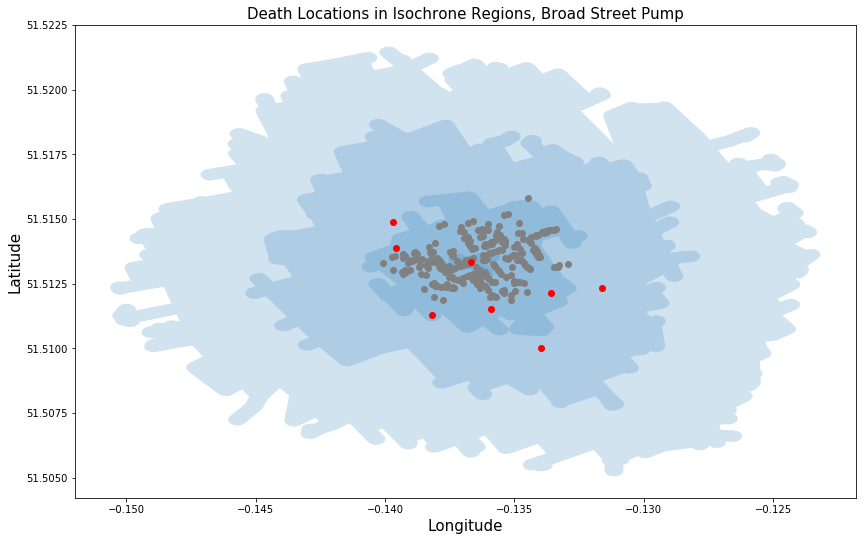

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,20))

# interval is [1, 5, 10, 15] minutes
for interval in trip_times:
    
    poly_gdf[interval].plot(ax=ax, alpha=0.2)

# plot cholera data
deaths_gdf.plot(ax=ax, color='gray')
pumps_gdf.plot(ax=ax, color='red')

ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
ax.set_title('Death Locations in Isochrone Regions, Broad Street Pump', fontsize=15)

### Draw a bar chart of death location counts per isochrone polygon (region)

Text(0.5, 1.0, 'Death Locations in Isochrone Regions, Broad Street Pump')

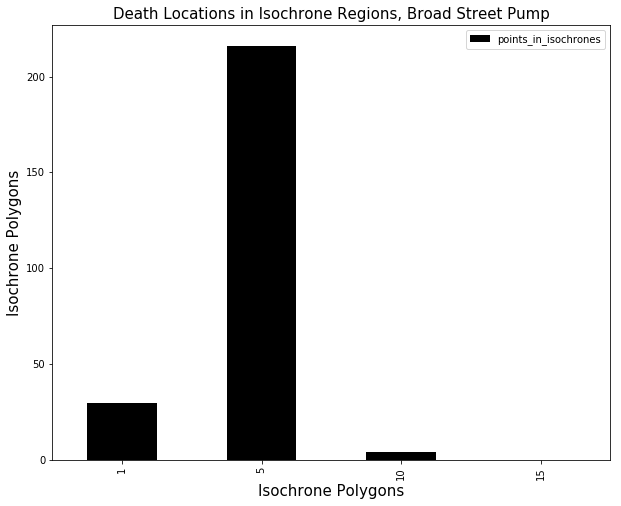

In [34]:
fig,ax = plt.subplots(figsize=(10,8))

pd.DataFrame(polys_gdf1[['trip_time','points_in_isochrones']])\
    .plot.bar(x='trip_time',color='black', ax=ax)

ax.set_xlabel('Isochrone Polygons', fontsize=15)
ax.set_ylabel('Isochrone Polygons', fontsize=15)
ax.set_title('Death Locations in Isochrone Regions, Broad Street Pump', fontsize=15)

## Let's draw the Folium Map

In [35]:
import folium
from folium import plugins

folium.__version__

'0.10.0'

In [36]:
map1 = folium.Map(location=BROAD_STREET_PUMP_COORDINATES, zoom_start=17, \
                 tiles='CARTODBPOSITRON')

deaths_df = pd.read_csv('resources/cholera_deaths.csv')

for index, row in polys_gdf1.iterrows():
    
    # adjust voronoi cell fill color based on points_in_voronoi value
    if row['points_in_isochrones'] > 200:
        color = 'red'
    elif row['points_in_isochrones'] <= 200 and row['points_in_isochrones'] > 40:
        color = 'orange'
    elif row['points_in_isochrones'] <= 40 and row['points_in_isochrones'] > 1:
        color = 'yellow'
    else:
        color = None
        
    # prepare for second "for" loop

    # create an empty list to hold lat,lon pairs 
    poly_list = []
    
    # extract x and y (lon and lat) from isochrone polygon (geometry column)
    x,y = row['geometry'].exterior.coords.xy
    
    # pair each x and y, like a zipper (zip)
    mapped = zip(x,y)
    
    # second "for" loop
    # create each polygon as lat, lon list (node the change in order)
    for lon,lat in mapped:
        poly_list.append([lat,lon])
    
    # add the folium Polygon
    folium.Polygon(poly_list,\
                    color='grey',\
                    weight=1,\
                    fill_opacity=0.1, \
                    fill_color=color).add_to(map1)    
    
locationlist = deaths_df[["LAT","LON"]].values.tolist()
radiuslist = deaths_df[["DEATHS"]].values.tolist()

# Iterate through the rows of the cholera deaths data frame 
#    and add each cholera death circle marker to map1
for i in range(0, len(locationlist)):

    # Each marker will show point information and 
    #   number of deaths in that location.
    #
    # Compose popup text as HTML string
    popup_text = '<b>Location:</b> '+'('+str(locationlist[i][0])+\
                 ', '+str(locationlist[i][1])+')'+\
                 '<br/>'+\
                 '<b>Deaths:</b> '+ str(radiuslist[i][0])
    # Create a popup for each marker
    popup_death = folium.Popup(popup_text, max_width=200)
    
    # Add each circle marker with popup representing 
    #   a location with deaths to map1
    folium.CircleMarker(
                    location=locationlist[i], \
                    radius=radiuslist[i], \
                    popup=popup_death, \
                    color='black', \
                    weight=1, \
                    fill=True, \
                    fill_color='red', \
                    fill_opacity=1).add_to(map1)
    
# Iterate through the rows of the pumps_df data frame 
#   and add each water pump to map1
for each in pumps_df.iterrows():
    
    # Each marker will show pump location information
    # Compose popup text
    popup_text = '<b>Location:</b> '+'('+str(each[1]['LAT'])+', '+str(each[1]['LON'])+')'+\
                 '<br/>'+\
                 '<b>Street Name:</b> '+each[1]['Street']
    # Create a popup for each marker
    popup_pump = folium.Popup(popup_text, max_width=200)

    # Add each circle marker with popup representing 
    #   a pump location to map1
    folium.RegularPolygonMarker([each[1]['LAT'],each[1]['LON']], \
                    color='black', \
                    weight=1,\
                    fill_opacity=1, \
                    fill_color='blue', \
                    number_of_sides=4, \
                    popup=popup_pump, \
                    radius=10).add_to(map1)
    
# let's use the "Fullscreen" plugin
# add the button to the top right corner
plugins.Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(map1)

map1

Don't forget to click on the Full Screen button to see the whole map display.

## References

1. Further Exploration #9: Isochrone Maps (Travel Time Maps). URL: http://datavizcatalogue.com/blog/isochrone-maps/
2. Boeing, G. Isochrone Maps with OSMnx + Python. URL: https://geoffboeing.com/2017/08/isochrone-maps-osmnx-python/
3. MapBox Isochrone Maps. URL: https://www.mapbox.com/bites/00156
4. https://en.wikipedia.org/wiki/Decimal_degrees


*For case study suggestions for improvement, please contact Herman Tolentino, Jan MacGregor, James Tobias or Zhanar Haimovich.*